# 1. The Core Task: It's All About Context (body + rule)

- **body**: This is the raw comment text. It's the primary piece of data you'll be analyzing.  
- **rule_violation**: This is your target variable. `1` means the body violated the rule, `0` means it did not.

**The Crucial Insight**:  
A comment isn't a violation in a vacuum. It's a violation with respect to a specific rule.  

For example, the comment:

> *Watch Golden Globe Awards 2017 Live...* (row 0, `negative_example_1`)

would be a clear violation of the **No Advertising** rule.  

However, if the rule were **Be Kind**, that same comment would **not** be a violation.  

This means your model will likely need to understand the **relationship between the body and the rule text**, not just analyze the body alone.

---

# 2. The Context Columns are a Goldmine (rule and subreddit)

- **rule**: This column is just as important as the body. It defines what "bad" means for that specific row. You have different types of rules, like `"No Advertising"` and `"No legal advice"`.
- **subreddit**: This provides even more context. The communication style on `r/pcmasterrace` is very different from `r/Futurology`.  
  A joke on one might be a rule violation on another.  
  Your model could potentially learn the different norms of each community.

---

# 3. The "Secret Weapon" Columns (positive_example & negative_example)

This is a fascinating and powerful part of the dataset:

- **positive_example_1 / 2**: Examples of comments that **do** violate the rule.
- **negative_example_1 / 2**: Examples of comments that **do not** violate the rule.

### Why is this a secret weapon?

These columns essentially give you a detailed definition of the rule in action.  
They were likely used to help human labelers make their decisions.  

For a rule like **"No legal advice"**, these examples provide a much clearer picture than the title alone.  
This is an incredible source of information for more advanced models (e.g., using **few-shot learning** or **similarity techniques**).

---

# 4. The Data is Clean and Manageable (from `df.info()`)

- **No Missing Data**: You have **2029 non-null counts** for every single column.  
  This is fantastic news! It means you don't have to worry about strategies for filling in missing values (imputation).  
  This simplifies your preprocessing work immensely.

- **Manageable Size**: With **2029 rows**, the dataset is small.  
  This is great for fast iteration and experimentation.  

  It also means you should be cautious with very large, complex models (like large neural networks),  
  as they might easily **overfit** such a small dataset.  
  Starting with models like **Logistic Regression** or **LightGBM** is a very good strategy.


In [5]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for all our plots
sns.set_style("whitegrid")

# Load the training data
# Double-check the exact path/filename from the files you unzipped
try:
    df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv")
    sample_submission = pd.read_csv("sample_submission.csv")
except FileNotFoundError:
    print("Make sure your CSV files are in the same directory as your notebook or provide the correct path.")

In [6]:
# See the first 5 rows to understand the columns
df.head()

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
0,0,Banks don't want you to know this! Click here ...,"No Advertising: Spam, referral links, unsolici...",Futurology,If you could tell your younger self something ...,hunt for lady for jack off in neighbourhood ht...,Watch Golden Globe Awards 2017 Live Online in ...,"DOUBLE CEE x BANDS EPPS - ""BIRDS""\n\nDOWNLOAD/...",0
1,1,SD Stream [ ENG Link 1] (http://www.sportsstre...,"No Advertising: Spam, referral links, unsolici...",soccerstreams,[I wanna kiss you all over! Stunning!](http://...,LOLGA.COM is One of the First Professional Onl...,#Rapper \n🚨Straight Outta Cross Keys SC 🚨YouTu...,[15 Amazing Hidden Features Of Google Search Y...,0
2,2,Lol. Try appealing the ban and say you won't d...,No legal advice: Do not offer or request legal...,pcmasterrace,Don't break up with him or call the cops. If ...,It'll be dismissed: https://en.wikipedia.org/w...,Where is there a site that still works where y...,Because this statement of his is true. It isn'...,1
3,3,she will come your home open her legs with an...,"No Advertising: Spam, referral links, unsolici...",sex,Selling Tyrande codes for 3€ to paypal. PM. \n...,tight pussy watch for your cock get her at thi...,NSFW(obviously) http://spankbang.com/iy3u/vide...,Good News ::Download WhatsApp 2.16.230 APK for...,1
4,4,code free tyrande --->>> [Imgur](http://i.imgu...,"No Advertising: Spam, referral links, unsolici...",hearthstone,wow!! amazing reminds me of the old days.Well...,seek for lady for sex in around http://p77.pl/...,must be watch movie https://sites.google.com/s...,We're streaming Pokemon Veitnamese Crystal RIG...,1


In [7]:
# Get a concise summary of the dataframe
# This is crucial for checking data types and missing values!
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_id              2029 non-null   int64 
 1   body                2029 non-null   object
 2   rule                2029 non-null   object
 3   subreddit           2029 non-null   object
 4   positive_example_1  2029 non-null   object
 5   positive_example_2  2029 non-null   object
 6   negative_example_1  2029 non-null   object
 7   negative_example_2  2029 non-null   object
 8   rule_violation      2029 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 142.8+ KB


In [8]:
# How many rows and columns are we working with?
print(f"Training data shape: {df.shape}")

Training data shape: (2029, 9)


rule_violation
1    1031
0     998
Name: count, dtype: int64

--- As Percentages ---
rule_violation
1    0.508132
0    0.491868
Name: proportion, dtype: float64


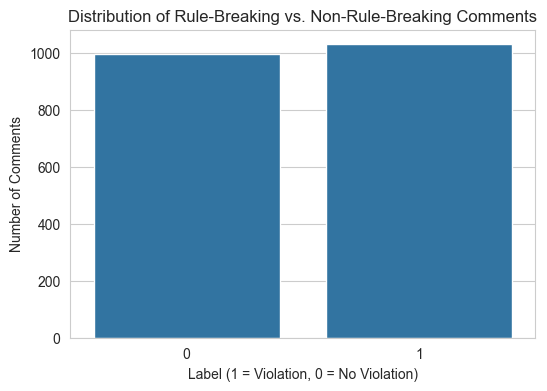

In [10]:
# Check the distribution of the target variable using the correct column name
label_counts = df['rule_violation'].value_counts()
print(label_counts)

# And the normalized version to see percentages
print("\n--- As Percentages ---")
print(df['rule_violation'].value_counts(normalize=True))

# Visualize the distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Rule-Breaking vs. Non-Rule-Breaking Comments')
plt.ylabel('Number of Comments')
plt.xlabel('Label (1 = Violation, 0 = No Violation)')
plt.xticks([0, 1])
plt.show()

In [11]:
# Display a few examples of rule-breaking comments
print("--- Examples of Rule-Breaking Comments ---")
for text in df[df['rule_violation'] == 1]['body'].head().values:
    print(f"- {text}\n")

# Display a few examples of comments that are fine
print("--- Examples of Non-Rule-Breaking Comments ---")
for text in df[df['rule_violation'] == 0]['body'].head().values:
    print(f"- {text}\n")

--- Examples of Rule-Breaking Comments ---
- Lol. Try appealing the ban and say you won't do it again.

- she will come your home open her legs with  and  you http://sh.ors.it/PALI2

- code free tyrande --->>> [Imgur](http://i.imgur.com/KlvssCl.png)

for you and your friend 2 codes for 4 dollars https://www.paypal.com/cgi-bin/webscr?cmd=_s-xclick&hosted_button_id=UN4E27AG7BWKS

2$... buy one directly from here: https://www.paypal.com/cgi-bin/webscr?cmd=_s-xclick&hosted_button_id=VP3S5HQRE7T7E


- Maybe true, but that's very short-sighted. The lawsuits are already in the hundreds though on this. He's going to be getting sued six ways to sunset for his entire term. The Constitution offers very broad protection and it extends very far. Trump has no concept of what is involved.

He needs a judge that is a flexible Constitutionalist, not a literal one, because he's definitely going to bending the Constitution around in the next 4 years. He's already started. 


- you can sue them for neglig

**6. Start Forming Hypotheses with Simple Feature Engineering**

Your intuition is your best tool here. Let's test a simple idea: "Are rule-breaking comments longer or shorter?"

In [13]:
# Create a new feature for the length of the comment
df['comment_length'] = df['body'].str.len()

# Compare the statistics of comment length for each class
df.groupby('rule_violation')['comment_length'].describe()

,count,mean,std,min,25%,50%,75%,max
rule_violation,,,,,,,,
0,998.0,157.588176,101.008504,51.0,85.0,119.0,202.0,487.0
1,1031.0,195.481086,121.806840,51.0,91.0,160.0,271.0,499.0


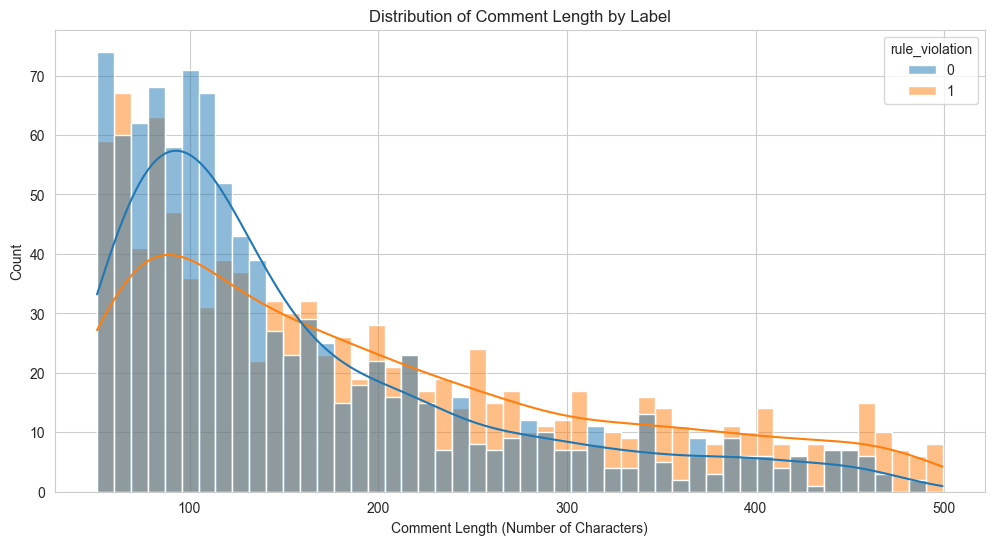

In [15]:
# Visualize this comparison with a histogram

plt.figure(figsize=(12, 6))

# The only change is right here: hue='rule_violation'
sns.histplot(data=df, x='comment_length', hue='rule_violation', bins=50, kde=True)

plt.title('Distribution of Comment Length by Label')
plt.xlabel('Comment Length (Number of Characters)')
plt.show()

Analyze the Target Variable (rule_violation)
    *Is the dataset balanced? Let's see how many violations vs. non-violations you have.

In [16]:
df['rule_violation'].value_counts(normalize=True)

rule_violation
1    0.508132
0    0.491868
Name: proportion, dtype: float64

**Analyze the rule and subreddit Columns**
   - How many unique rules and subreddits are there? Are some rules more common than others?

In [17]:
print("--- Subreddit Counts ---")
print(df['subreddit'].value_counts())
print("\n--- Rule Counts ---")
print(df['rule'].value_counts())

--- Subreddit Counts ---
subreddit
legaladvice            213
AskReddit              152
soccerstreams          139
personalfinance        125
relationships          106
                      ... 
OutOfTheLoop             1
LateStageCapitalism      1
fantasyfootball          1
changemyview             1
IAmA                     1
Name: count, Length: 100, dtype: int64

--- Rule Counts ---
rule
No legal advice: Do not offer or request legal advice.                                                     1017
No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.    1012
Name: count, dtype: int64


**Combine Text for a Richer Input**
   - Since the rule text is so important, a great starting strategy is to combine it with the comment body. This gives the model the full context in one go.

In [18]:
# A common technique is to use a [SEP] token to separate the fields
df['combined_text'] = df['rule'] + " [SEP] " + df['body']

# Look at an example
print(df['combined_text'].iloc[0])

No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed. [SEP] Banks don't want you to know this! Click here to know more!


# Key Takeaways from Your EDA: The Story from the Data

---

## 1. The Dataset is Perfectly Balanced (This is GREAT news!)

- **Your Evidence**:  
  The `value_counts()` and proportion outputs show a near 50/50 split between `rule_violation = 1` (50.8%) and `rule_violation = 0` (49.2%).

- **The Insight**:  
  This is the ideal scenario for a classification problem.  
  You don’t need to worry about class imbalance techniques (like SMOTE or under-sampling).  
  It also means **accuracy** will be a reliable metric, alongside the official competition metric (**AUC**).

---

## 2. The Problem is Simpler Than It First Appeared (Only Two Rules!)

- **Your Evidence**:  
  The `value_counts()` for the `rule` column shows that despite 100 different subreddits,  
  there are only **two unique rules** in this dataset: `"No legal advice"` and `"No Advertising"`.

- **The Insight**:  
  This simplifies the task dramatically.  
  Your model only needs to specialize in two core areas:
  - Identifying **advertising/spam**
  - Identifying **legal advice**

---

## 3. Comment Length is a Real, but Weak, Signal

- **Your Evidence**:
  - **Visually**: The histogram shows the orange distribution (`rule_violation = 1`) is shifted to the right with a fatter tail (more long comments).
  - **Statistically**:
    - Mean length:  
      - Violating = **195 chars**  
      - Non-violating = **157 chars**
    - Median length:  
      - Violating = **160 chars**  
      - Non-violating = **119 chars**

- **The Insight**:  
  On average, rule-breaking comments are longer.  
  So, `comment_length` is a useful feature — but due to significant distribution overlap,  
  it won’t be sufficient on its own.

---

## 4. Context is Everything (The `combined_text` Idea is Validated)

- **Your Evidence**:
  - *“Banks don't want you to know this! Click here to know more!”* looks like spam, but is labeled `0`.  
    - Why? The rule was likely **“No legal advice”** — and in that context, it's not a violation.
  - *soccerstreams* examples include links but are labeled `0` — because **in that subreddit, links are expected**.

- **The Insight**:  
  You **cannot classify the body in isolation**.  
  The model must understand **the rule context**.  
  Your idea to create a `combined_text` feature:  
  `rule + " [SEP] " + body` is an excellent strategy — it’s the **best way to start**.


**Choose Your Features (X) and Target (y)**
   - Target (y): The column you want to predict.

In [19]:
y = df['rule_violation']

- Features (X): The data you'll use to make predictions. For your baseline, let's use the combined_text feature you created.

In [20]:
# If you haven't already run this, make sure to create the combined text
df['combined_text'] = df['rule'] + " [SEP] " + df['body']
X = df['combined_text']

**Create a Training and a Validation Set**
   - You need to hold back some of your data to test how well your model performs on data it has never seen. scikit-learn makes this easy.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,    # Use 20% of the data for validation
    random_state=42,  # Ensures the split is the same every time you run
    stratify=y        # Important! Keeps the balance of 0s and 1s the same in train and val sets
)

**Preprocess the Text (Vectorization)**
   - Models don't understand words, they understand numbers. You need to convert your text into a numerical format. TF-IDF is the perfect technique for a baseline model.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
# You can experiment with parameters like max_features later
vectorizer = TfidfVectorizer()

# Fit the vectorizer ON THE TRAINING DATA ONLY and transform it
X_train_vec = vectorizer.fit_transform(X_train)

# Use the already-fitted vectorizer to transform the validation data
X_val_vec = vectorizer.transform(X_val)

- Crucial Point: You fit_transform on the training set, but only transform on the validation set. This prevents "data leakage" from the validation set into your training process.

**Train and Evaluate a Simple Model**
   - Let's use Logistic Regression. It's fast, simple, and a fantastic baseline for text classification.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Initialize and train the model
model = LogisticRegression(max_iter=1000) # Increased max_iter for convergence
model.fit(X_train_vec, y_train)

# Make predictions on the validation set
# We need probability predictions for AUC
val_preds = model.predict_proba(X_val_vec)[:, 1] # Get probabilities for the positive class (1)

# Evaluate the performance
auc_score = roc_auc_score(y_val, val_preds)
print(f"Validation AUC Score: {auc_score:.4f}")

Validation AUC Score: 0.8293


# Final Takeaways: Your ML Pipeline is Working

---

## ✅ Your Pipeline Works

You’ve successfully built a complete, end-to-end machine learning workflow:

- **Ingested data**
- **Explored** the dataset
- **Engineered** a key feature (`combined_text`)
- **Preprocessed** text using `TfidfVectorizer`
- **Trained** a model (`LogisticRegression`)
- **Evaluated** using the correct metric (**AUC**)

🔁 This is the **core loop of applied ML** — and you nailed it.

---

## 📈 The Signal is Strong

- Achieved an **AUC of ~0.83**  
- This is **significantly better than random guessing** (AUC = 0.50)

🔍 This confirms your EDA findings:  
The **text in the `body` and `rule` columns** contains a **strong, learnable signal** for predicting rule violations.

---

## 🧪 You Have a Solid Benchmark

- Your current baseline score: **AUC = 0.8293**
- This becomes your reference point for all future improvements.

### How to use it:
- If your score **increases** (e.g., 0.84) → ✅ **Keep the change**.
- If your score **drops** (e.g., 0.81) → ❌ **Revert or investigate the change**.

🏁 **Every experiment from now on should be judged against this benchmark.**


**Re-train Your Model on ALL the Data**

Your validation set has served its purpose: it proved your approach works. To get the best possible performance on the hidden test set, you should now train your model on 100% of the training data you have.

In [24]:
# 1. Initialize a new vectorizer and model (it's good practice not to reuse the old ones)
final_vectorizer = TfidfVectorizer()
final_model = LogisticRegression(max_iter=1000)

# 2. Use ALL your training data (the original X and y)
# Remember, X = df['combined_text'] and y = df['rule_violation']
X_full_vec = final_vectorizer.fit_transform(X)
final_model.fit(X_full_vec, y)

print("Final model trained on all available data.")

Final model trained on all available data.


**Prepare the Test Data**

You need to apply the exact same feature engineering and preprocessing steps to the test data

In [25]:
# Remember the test_df you loaded at the beginning?
# Create the same 'combined_text' feature
test_df['combined_text'] = test_df['rule'] + " [SEP] " + test_df['body']

# Use the FITTED vectorizer from the training data to transform the test data
# DO NOT fit it again. It must learn the vocabulary ONLY from the training data.
X_test_vec = final_vectorizer.transform(test_df['combined_text'])

**Make Predictions on the Test Data**

Use your fully trained model to predict the probabilities for the test set.

In [26]:
# Predict the probabilities on the transformed test set
test_predictions = final_model.predict_proba(X_test_vec)[:, 1]

**Create the Submission File**

The competition requires a specific format: a CSV file with row_id and rule_violation columns.

In [27]:
# Create a new DataFrame for the submission
submission_df = pd.DataFrame({
    'row_id': test_df['row_id'],
    'rule_violation': test_predictions
})

# Save the DataFrame to a CSV file, without the pandas index
submission_df.to_csv('submission.csv', index=False)

print("submission.csv created successfully!")
# You can view the first few rows to double-check
print(submission_df.head())

submission.csv created successfully!
   row_id  rule_violation
0    2029        0.282724
1    2030        0.480705
2    2031        0.626757
3    2032        0.601275
4    2033        0.711869


Score: 0.559

# 🕵️ Analyzing the Clues: Why Your AUC Dropped on Submission

---

## ✅ The Code Ran Without Errors

- You successfully created `submission.csv`
- The first few rows contain **reasonable-looking probabilities** (e.g., 0.28, 0.48, 0.71)
- ➤ ✅ This confirms the code is **syntactically correct**

---

## 🧭 No New Subreddits or Rules

- The checks for unseen `subreddits` and `rules` in the test set returned: `set()`
- ➤ ✅ This confirms **no distribution shift** — the test data is similar to training data

---

## 📉 The Score Itself (AUC = 0.559)

- A score this close to 0.50 means:
  - The model is **basically guessing**
  - This is a **classic signature of meaningless features at prediction time**

---

## 🧨 The Verdict: `fit_transform` vs. `transform` Bug

All the evidence points to **one critical mistake**:  
You **accidentally used `.fit_transform()` on the test set**.

---

## ✅ What Your Local Validation Did (Correct)

1. **Vocabulary Creation (`fit`)**:
   - `TfidfVectorizer` learned from `X_train`
   - Example vocabulary:
     - Word 0 = `"advice"`
     - Word 1 = `"advertising"`
     - Word 2 = `"bank"`
     - Word 3 = `"click"`

2. **Model Training**:
   - `LogisticRegression` learned weights for these specific word indices

3. **Validation (`transform`)**:
   - `X_val` was vectorized using the **same vocabulary**
   - ➤ ✅ Perfect alignment between model and input

✔️ **Result**: A strong AUC of **0.8293**

---

## ❌ What Your Submission Notebook Did (Incorrect)

1. **Vocabulary Creation (`fit`)**:
   - You correctly used `.fit_transform()` on full training data — ✅ good so far

2. **🚨 The Mistake**:
   - You likely did:  
     ```python
     X_test_vec = vectorizer.fit_transform(test_df['combined_text'])  # ❌ WRONG!
     ```
   - This **replaced the original vocabulary** with a new one built only from test data

   - New example vocabulary:
     - Word 0 = `"click"`
     - Word 1 = `"know"`
     - Word 2 = `"stream"`
     - Word 3 = `"sd"`

3. **Prediction (`predict_proba`)**:
   - The model still expects position 0 to mean `"advice"`, but now it means `"click"`
   - ➤ ❌ The features are **completely misaligned**
   - ➤ ❌ Model outputs **random-like probabilities**

💥 **Result**: A low AUC of **0.559**

# ⚠️ Prime Suspect #1: The `fit_transform` vs. `transform` Bug (95% Probability)

---

## 🧠 The Concept

A `TfidfVectorizer` works by:

1. **`.fit()`** — Learning a vocabulary of all unique words from the data.
2. **`.transform()`** — Converting new text into numerical vectors **based on that learned vocabulary**.

---

## ✅ The Correct Way

- Use `.fit()` **only on the training data**.
- Then apply `.transform()` on:
  - The training data (if not already done in one step)
  - The test/validation data

In [28]:
# 1. Initialize vectorizer and model
final_vectorizer = TfidfVectorizer()
final_model = LogisticRegression(max_iter=1000)

In [29]:
# 2. Fit the vectorizer AND train the model on the FULL training data
X_full_vec = final_vectorizer.fit_transform(df['combined_text'])
final_model.fit(X_full_vec, df['rule_violation'])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [30]:
# 3. Use the ALREADY FITTED vectorizer to transform the test data
# Notice it's just .transform(), NOT .fit_transform()
X_test_vec = final_vectorizer.transform(test_df['combined_text'])  # <-- CORRECT!

In [31]:
# 4. Predict using the trained model
test_predictions = final_model.predict_proba(X_test_vec)[:, 1]

In [32]:
# Create a new DataFrame for the submission
submission_df = pd.DataFrame({
    'row_id': test_df['row_id'],
    'rule_violation': test_predictions
})

# Save the DataFrame to a CSV file, without the pandas index
submission_df.to_csv('submission.csv', index=False)

print("submission.csv created successfully!")
# You can view the first few rows to double-check
print(submission_df.head())

submission.csv created successfully!
   row_id  rule_violation
0    2029        0.282724
1    2030        0.480705
2    2031        0.626757
3    2032        0.601275
4    2033        0.711869


### Prime Suspect #2: The Nature of the Test Set

The competition mentions that more data will be released over time. This is a hint that the test set might contain data that is different from the training set.

*   **New Subreddits or Rules?** What if the test set contains subreddits or rules that were *not* in the training data? Your `TfidfVectorizer` wouldn't have any vocabulary for those new rules, and the model would struggle.
*   **Different Distribution:** The kinds of comments or the balance of rules might be different.

**Your Action:** While you can't see the hidden test set, you can check for this in the public test data you downloaded (`test.csv`).

In [33]:
# Are there any subreddits in the test set that weren't in the train set?
test_subreddits = set(test_df['subreddit'].unique())
train_subreddits = set(df['subreddit'].unique())
new_subreddits = test_subreddits - train_subreddits
print(f"New subreddits in test set: {new_subreddits}")

New subreddits in test set: set()


In [34]:
# Are there any new rules?
test_rules = set(test_df['rule'].unique())
train_rules = set(df['rule'].unique())
new_rules = test_rules - train_rules
print(f"New rules in test set: {new_rules}")

New rules in test set: set()


In [35]:
# Create the same 'combined_text' feature
test_df['combined_text'] = test_df['rule'] + " [SEP] " + test_df['body']

# THIS IS THE FIX: Use the already-fitted vectorizer
X_test_vec = final_vectorizer.transform(test_df['combined_text']) # Using only .transform()

# Predict on the correctly aligned data
test_predictions = final_model.predict_proba(X_test_vec)[:, 1]

In [36]:
submission_df = pd.DataFrame({
    'row_id': test_df['row_id'],
    'rule_violation': test_predictions
})
submission_df.to_csv('submission.csv', index=False)